In [1]:
%matplotlib inline


# Advection correction

This tutorial shows how to use the optical flow routines of pysteps to implement
the advection correction procedure described in Anagnostou and Krajewski (1999).

Advection correction is a temporal interpolation procedure that is often used
when estimating rainfall accumulations to correct for the shift of rainfall patterns
between consecutive radar rainfall maps. This shift becomes particularly 
significant for long radar scanning cycles and in presence of fast moving
precipitation features.

<div class="alert alert-info"><h4>Note</h4><p>The code for the advection correction using pysteps was originally
          written by `Daniel Wolfensberger <https://github.com/wolfidan>`_.</p></div>


In [2]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np

from pysteps import io, motion, rcparams
from pysteps.utils import conversion, dimension
from pysteps.visualization import plot_precip_field
from scipy.ndimage import map_coordinates

Pysteps configuration file found at: /home/runner/.pysteps/pystepsrc



## Read the radar input images

First, we import a sequence of 36 images of 5-minute radar composites
that we will use to produce a 3-hour rainfall accumulation map.
We will keep only one frame every 10 minutes, to simulate a longer scanning
cycle and thus better highlight the need for advection correction.

You need the pysteps-data archive downloaded and the pystepsrc file
configured with the data_source paths pointing to data folders.



In [3]:
# Selected case
date = datetime.strptime("201607112100", "%Y%m%d%H%M")
data_source = rcparams.data_sources["mch"]

### Load the data from the archive



In [4]:
root_path = data_source["root_path"]
path_fmt = data_source["path_fmt"]
fn_pattern = data_source["fn_pattern"]
fn_ext = data_source["fn_ext"]
importer_name = data_source["importer"]
importer_kwargs = data_source["importer_kwargs"]
timestep = data_source["timestep"]

# Find the input files from the archive
fns = io.archive.find_by_date(
    date, root_path, path_fmt, fn_pattern, fn_ext, timestep=5, num_next_files=35
)

# Read the radar composites
importer = io.get_method(importer_name, "importer")
R, __, metadata = io.read_timeseries(fns, importer, **importer_kwargs)

# Convert to mm/h
R, metadata = conversion.to_rainrate(R, metadata)

# Upscale to 2 km (simply to reduce the memory demand)
R, metadata = dimension.aggregate_fields_space(R, metadata, 2000)

# Keep only one frame every 10 minutes (i.e., every 2 timesteps)
# (to highlight the need for advection correction)
R = R[::2]

## Advection correction

Now we need to implement the advection correction for a pair of successive
radar images. The procedure is based on the algorithm described in Anagnostou
and Krajewski (Appendix A, 1999).

To evaluate the advection occurred between two successive radar images, we are
going to use the Lucas-Kanade optical flow routine available in pysteps.



In [5]:
def advection_correction(R, T=5, t=1):
    """
    R = np.array([qpe_previous, qpe_current])
    T = time between two observations (5 min)
    t = interpolation timestep (1 min)
    """

    # Evaluate advection
    oflow_method = motion.get_method("LK")
    fd_kwargs = {"buffer_mask": 10}  # avoid edge effects
    V = oflow_method(np.log(R), fd_kwargs=fd_kwargs)

    # Perform temporal interpolation
    Rd = np.zeros((R[0].shape))
    x, y = np.meshgrid(
        np.arange(R[0].shape[1], dtype=float), np.arange(R[0].shape[0], dtype=float)
    )
    for i in range(t, T + t, t):

        pos1 = (y - i / T * V[1], x - i / T * V[0])
        R1 = map_coordinates(R[0], pos1, order=1)

        pos2 = (y + (T - i) / T * V[1], x + (T - i) / T * V[0])
        R2 = map_coordinates(R[1], pos2, order=1)

        Rd += (T - i) * R1 + i * R2

    return t / T ** 2 * Rd

Finally, we apply the advection correction to the whole sequence of radar
images and produce the rainfall accumulation map.



In [6]:
R_ac = R[0].copy()
for i in range(R.shape[0] - 1):
    R_ac += advection_correction(R[i : (i + 2)], T=10, t=1)
R_ac /= R.shape[0]

## Results

We compare the two accumulation maps. The first map on the left is
computed without advection correction and we can therefore see that the shift
between successive images 10 minutes apart produces irregular accumulations.
Conversely, the rainfall accumulation of the right is produced using advection
correction to account for this spatial shift. The final result is a smoother
rainfall accumulation map.



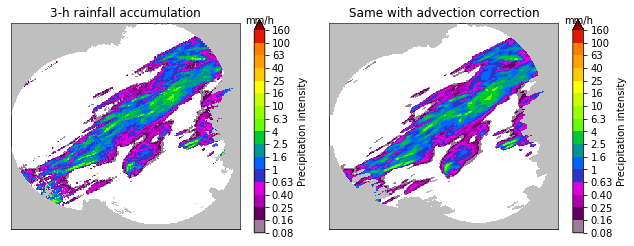

In [7]:
plt.figure(figsize=(9, 4))
plt.subplot(121)
plot_precip_field(R.mean(axis=0), title="3-h rainfall accumulation")
plt.subplot(122)
plot_precip_field(R_ac, title="Same with advection correction")
plt.tight_layout()
plt.show()

### Reference

Anagnostou, E. N., and W. F. Krajewski. 1999. "Real-Time Radar Rainfall
Estimation. Part I: Algorithm Formulation." Journal of Atmospheric and
Oceanic Technology 16: 189–97.
https://doi.org/10.1175/1520-0426(1999)016<0189:RTRREP>2.0.CO;2

